In [27]:
# Cell 1
import os, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import get_source_inputs
import random

DATASET = "KTH"
CLASS_NAMES = ["boxing","handclapping","handwaving","walking"]
NUM_CLASSES = len(CLASS_NAMES)
EPOCHS = 500
BATCH_SIZE = 64
MODEL_ARCH = "64"
USE_CONTEXT = True
USE_FOVEA = True
CONTEXT_SHAPE = (64,64,1)
FOVEA_SHAPE = (32,32,1)
REVERSE_RESOLUTION = False
PREPROCESSED_DIR = f"/mnt/60FE87C2FE878F4A/Uni/Master's/Term2/Edge/Replication/datasets/{DATASET}/preprocessed_frames"
context_res = f"{CONTEXT_SHAPE[0]}x{CONTEXT_SHAPE[1]}"
fovea_res = f"{FOVEA_SHAPE[0]}x{FOVEA_SHAPE[1]}"
mode_tag = f"reverseResolution{MODEL_ARCH}" if REVERSE_RESOLUTION else f"both{MODEL_ARCH}" if (USE_CONTEXT and USE_FOVEA) else f"contextOnly{MODEL_ARCH}" if USE_CONTEXT else f"foveaOnly{MODEL_ARCH}"
OUTPUT_DIR = f"{DATASET}_results/{mode_tag}_{EPOCHS}_{BATCH_SIZE}{'_ctx'+str(CONTEXT_SHAPE[0])+'x'+str(CONTEXT_SHAPE[1]) if USE_CONTEXT else ''}{'_fov'+str(FOVEA_SHAPE[0])+'x'+str(FOVEA_SHAPE[1]) if USE_FOVEA else ''}"
CHECKPOINTS_DIR = os.path.join(OUTPUT_DIR,"checkpoints")
PLOTS_DIR = os.path.join(OUTPUT_DIR,"plots")
os.makedirs(PLOTS_DIR, exist_ok=True)
FOLD = 1
STREAM = "context"
OUT_NAME = f"gradcam_fold{FOLD}_{STREAM}.png"


In [28]:
# Cell 2
if MODEL_ARCH == "64":
    CHANNEL1_SIZE = 16; CHANNEL2_SIZE = 16; DENSE1_SIZE = 10; DENSE2_SIZE = 16
elif MODEL_ARCH == "32":
    CHANNEL1_SIZE = 16; CHANNEL2_SIZE = 32; DENSE1_SIZE = 20; DENSE2_SIZE = 32
else:
    CHANNEL1_SIZE = 8; CHANNEL2_SIZE = 16; DENSE1_SIZE = 8; DENSE2_SIZE = 8

def build_branch(input_shape, name_prefix=""):
    inp = keras.Input(shape=input_shape, name=f"{name_prefix}input")
    x = layers.Conv2D(CHANNEL1_SIZE,(3,3),kernel_initializer="he_normal",bias_initializer="zeros")(inp)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(CHANNEL2_SIZE,(3,3),kernel_initializer="he_normal",bias_initializer="zeros")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    return inp, x

def build_model(use_context,use_fovea,context_input_shape, fovea_input_shape, num_classes):
    inputs, branches = [], []
    if use_context:
        ci, co = build_branch(context_input_shape, "context_"); inputs.append(ci); branches.append(co)
    if use_fovea:
        fi, fo = build_branch(fovea_input_shape, "fovea_"); inputs.append(fi); branches.append(fo)
    fused = branches[0] if len(branches)==1 else layers.Concatenate()(branches)
    z = layers.Dense(DENSE1_SIZE, kernel_initializer="he_normal", bias_initializer="zeros")(fused)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(DENSE2_SIZE, kernel_initializer="he_normal", bias_initializer="zeros")(z)
    z = layers.Dropout(0.5)(z)
    out = layers.Dense(num_classes, activation="softmax", kernel_initializer="he_normal", bias_initializer="zeros")(z)
    return Model(inputs=inputs, outputs=out)

def last_conv_for_stream(model, input_prefix):
    target_input_name = f"{input_prefix}input"
    for l in reversed(model.layers):
        if isinstance(l, tf.keras.layers.Conv2D):
            srcs = get_source_inputs(l.output)
            if any(si.name.startswith(target_input_name) for si in srcs):
                return l
    raise ValueError("no Conv2D connected to the requested stream was found")

def read_png(path, hw):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, hw)
    return img

def pick_one_per_class(base_dir, split, res, classes):
    out = []
    for c in classes:
        d = os.path.join(base_dir, split, res, c)
        fs = [f for f in sorted(os.listdir(d)) if f.lower().endswith(".png")]
        out.append(os.path.join(d, random.choice(fs)))
    return out

def gradcam(model, inputs, class_index, target_layer):
    grad_model = Model(model.inputs, [target_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(inputs, training=False)
        loss = preds[:, class_index]
    grads = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(1,2))
    cam = tf.reduce_sum(tf.multiply(weights[:,None,None,:], conv_out), axis=-1)
    cam = tf.nn.relu(cam)
    cam = cam / (tf.reduce_max(cam, axis=(1,2), keepdims=True) + 1e-12)
    cam = cam ** 0.5
    return cam.numpy()[0]


def overlay(gray01, heat01, alpha=0.45):
    cmap = plt.cm.jet
    heat_rgb = cmap(heat01)[..., :3]
    gray_rgb = np.repeat(gray01, 3, axis=-1)
    return np.clip(alpha*heat_rgb + (1-alpha)*gray_rgb, 0, 1)


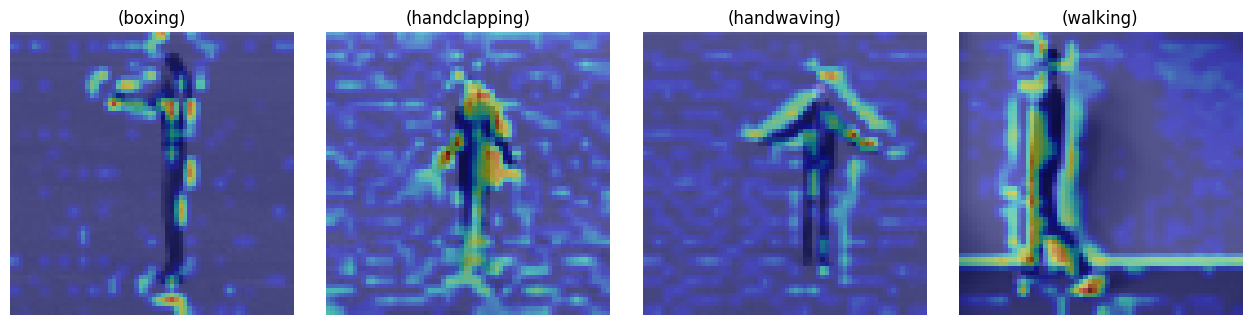

KTH_results/both64_500_64_ctx64x64_fov32x32/plots/gradcam_fold1_context.png


In [32]:
# Cell 3
if STREAM == "context":
    vis_hw = (CONTEXT_SHAPE[0], CONTEXT_SHAPE[1]); res_dir = context_res; prefix = "context_"
else:
    vis_hw = (FOVEA_SHAPE[0], FOVEA_SHAPE[1]); res_dir = f"centerCrop_{fovea_res}"; prefix = "fovea_"
paths_ctx = pick_one_per_class(PREPROCESSED_DIR, "test", context_res, CLASS_NAMES) if USE_CONTEXT else [None]*NUM_CLASSES
paths_fov = pick_one_per_class(PREPROCESSED_DIR, "test", f"centerCrop_{fovea_res}", CLASS_NAMES) if USE_FOVEA else [None]*NUM_CLASSES
model_gc = build_model(USE_CONTEXT, USE_FOVEA, CONTEXT_SHAPE, FOVEA_SHAPE, NUM_CLASSES)
model_gc.load_weights(os.path.join(CHECKPOINTS_DIR, f"fold_{FOLD}_best_model.keras"))
target_layer = last_conv_for_stream(model_gc, prefix)
n = NUM_CLASSES
plt.figure(figsize=(3.2*n,3.2))
for i, cls in enumerate(CLASS_NAMES):
    if STREAM == "context":
        base_img = read_png(paths_ctx[i], vis_hw)
        inp_ctx = tf.expand_dims(read_png(paths_ctx[i], (CONTEXT_SHAPE[0], CONTEXT_SHAPE[1])), 0) if USE_CONTEXT else None
        inp_fov = tf.expand_dims(read_png(paths_fov[i], (FOVEA_SHAPE[0], FOVEA_SHAPE[1])), 0) if USE_FOVEA else None
    else:
        base_img = read_png(paths_fov[i], vis_hw)
        inp_ctx = tf.expand_dims(read_png(paths_ctx[i], (CONTEXT_SHAPE[0], CONTEXT_SHAPE[1])), 0) if USE_CONTEXT else None
        inp_fov = tf.expand_dims(read_png(paths_fov[i], (FOVEA_SHAPE[0], FOVEA_SHAPE[1])), 0) if USE_FOVEA else None
    inputs = []
    if USE_CONTEXT: inputs.append(inp_ctx)
    if USE_FOVEA: inputs.append(inp_fov)
    if len(inputs)==1: inputs = inputs[0]
    cam = gradcam(model_gc, inputs, i, target_layer)
    cam = tf.image.resize(cam[...,None], vis_hw).numpy()[...,0]
    ov = overlay(base_img.numpy(), cam)
    ax = plt.subplot(1,n,i+1)
    ax.imshow(ov); ax.set_axis_off(); ax.set_title(f"({cls})")
plt.tight_layout()
out_path = os.path.join(PLOTS_DIR, OUT_NAME)
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print(out_path)